In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [4]:
from google.cloud import bigquery

In [5]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./adept-comfort-307720-db5f8ca3ee46.json"
client = bigquery.Client()

In [6]:
%load_ext google.cloud.bigquery

In [7]:
%%bigquery state_2018_5yr
SELECT *
FROM
    `bigquery-public-data.census_bureau_acs.state_2018_5yr`

Downloading: 100%|██████████| 52/52 [00:02<00:00, 25.10rows/s]


In [8]:
 state_2018_5yr.shape

(52, 242)

In [9]:
for col in state_2018_5yr.columns:
    print(col)

geo_id
do_date
total_pop
households
male_pop
female_pop
median_age
male_under_5
male_5_to_9
male_10_to_14
male_15_to_17
male_18_to_19
male_20
male_21
male_22_to_24
male_25_to_29
male_30_to_34
male_35_to_39
male_40_to_44
male_45_to_49
male_50_to_54
male_55_to_59
male_60_to_61
male_62_to_64
male_65_to_66
male_67_to_69
male_70_to_74
male_75_to_79
male_80_to_84
male_85_and_over
female_under_5
female_5_to_9
female_10_to_14
female_15_to_17
female_18_to_19
female_20
female_21
female_22_to_24
female_25_to_29
female_30_to_34
female_35_to_39
female_40_to_44
female_45_to_49
female_50_to_54
female_55_to_59
female_60_to_61
female_62_to_64
female_65_to_66
female_67_to_69
female_70_to_74
female_75_to_79
female_80_to_84
female_85_and_over
white_pop
population_1_year_and_over
population_3_years_over
pop_5_years_over
pop_15_and_over
pop_16_over
pop_25_years_over
pop_25_64
pop_never_married
pop_now_married
pop_separated
pop_widowed
pop_divorced
not_us_citizen_pop
black_pop
asian_pop
hispanic_pop
amerindi

In [10]:
allStates_pop = state_2018_5yr['total_pop'].sum()
average_income =  ((state_2018_5yr['income_per_capita']*state_2018_5yr['total_pop']).sum())/allStates_pop
average_income

32411.262103872632

In [11]:
bins_ = [
    'income_less_10000',
    'income_10000_14999',
    'income_15000_19999',
    'income_20000_24999',
    'income_25000_29999',
    'income_30000_34999',
    'income_35000_39999',
    'income_40000_44999',
    'income_45000_49999',
    'income_50000_59999',
    'income_60000_74999',
    'income_75000_99999',
    'income_100000_124999',
    'income_125000_149999',
    'income_150000_199999',
    'income_200000_or_more'
]
binMiddle = [
    5000,
    12500,
    17500,
    22500,
    27500,
    32500,
    37500,
    42500,
    47500,
    55000,
    67500,
    87500,
    112500,
    137500,
    175000,
    300000
    
]
def median_income(obs):
    household=0
    for idx,bin_ in enumerate(bins_):
        household += obs[bin_]
        if household >= obs['medianPoint']:
            return binMiddle[idx]
        

state_2018_5yr['medianPoint'] = state_2018_5yr['households']/2

state_2018_5yr['stateIncomeMedian'] = state_2018_5yr.apply(lambda row:median_income(row),axis=1)

In [12]:
state_2018_5yr['stateIncomeMedian'].skew()

0.4030263027821765

In [59]:
import numpy as np
bins_df = pd.DataFrame(np.column_stack([bins_, binMiddle]), columns=['income_bin', 'bin_avg_income'])
bins_df['bin_avg_income']= bins_df['bin_avg_income'].astype(int)

In [13]:
state_2018_5yr['stateIncomeMedian'].mean()

60913.46153846154

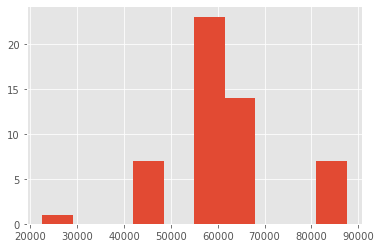

In [14]:
plt.hist(state_2018_5yr['stateIncomeMedian']);


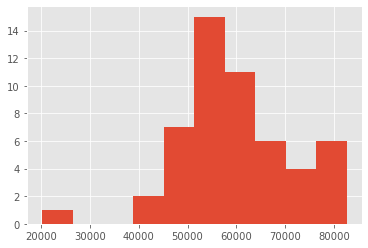

In [15]:
plt.hist(state_2018_5yr['median_income']);

In [16]:
state_2018_5yr['median_income'].skew()

-0.30425115515767487

In [108]:
#Check weighted mean and median values
import weightedstats as ws

print(f"weighted median_income: ${ws.numpy_weighted_median(state_df['median_income'], weights = state_df['households'])}")
print(f"weighted our calculated median: ${ws.numpy_weighted_median(state_df['stateIncomeMedian'], weights = state_df['households'])}")

print(f"weighted mean: ${round(ws.numpy_weighted_mean(state_df['median_income'], weights = state_df['households']), 2)}")


weighted median_income: $59445.0
weighted our calculated median: $55000
weighted mean: $60752.66


In [102]:
#Use the avg value of each income bin
state_df = pd.melt(state_2018_5yr, id_vars= ['geo_id','total_pop', 'households','median_income',
                                             'income_per_capita', 'stateIncomeMedian'],
                   value_vars = bins_, var_name = "income_bin", value_name ='households_in_bin')
state_df = pd.merge(state_df, bins_df, on= 'income_bin', how =  'left')

In [103]:
state_df.sample(5)

,geo_id,total_pop,households,median_income,income_per_capita,stateIncomeMedian,income_bin,households_in_bin,bin_avg_income
361,08,5531141.0,2113387.0,68811.0,36415.0,67500,income_35000_39999,87818.0,37500
815,30,1041732.0,423240.0,52559.0,29765.0,55000,income_200000_or_more,16939.0,300000
410,35,2092434.0,775651.0,48059.0,26085.0,47500,income_40000_44999,34927.0,42500
798,34,8881845.0,3213362.0,79363.0,40895.0,87500,income_200000_or_more,416737.0,300000
227,17,12821497.0,4830038.0,63575.0,34463.0,67500,income_25000_29999,206622.0,27500


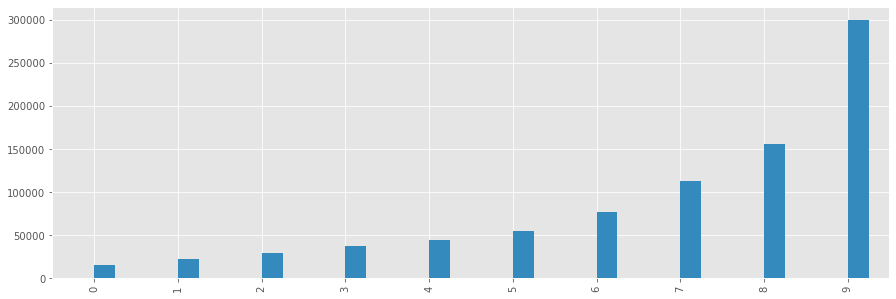

In [109]:
by_bin = state_df.groupby('income_bin', as_index = False).agg( median_inc = ('bin_avg_income', 'median'))
usa_quantiles = by_bin.quantile([.1, .2,.3,.4, .5,.6,.7,.8,.9,1]).reset_index().rename(columns = {'index': 'percentile'})
usa_quantiles.plot.bar(figsize=(15, 5), legend= None);

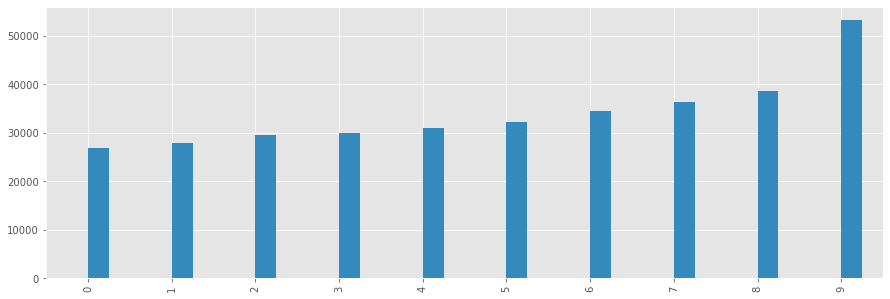

In [126]:
usa_quantiles2 = state_df['income_per_capita'].quantile(
    [.1, .2,.3,.4, .5,.6,.7,.8,.9,1]).reset_index().rename(columns = {'index': 'percentile'})
usa_quantiles2.plot.bar(figsize=(15, 5), legend= None);

In [123]:
usa_quantiles2

,percentile,income_per_capita
0,0.1,26772.0
1,0.2,27986.0
2,0.3,29456.0
3,0.4,29961.0
4,0.5,30921.0
5,0.6,32295.0
6,0.7,34463.0
7,0.8,36245.0
8,0.9,38548.0
9,1.0,53321.0


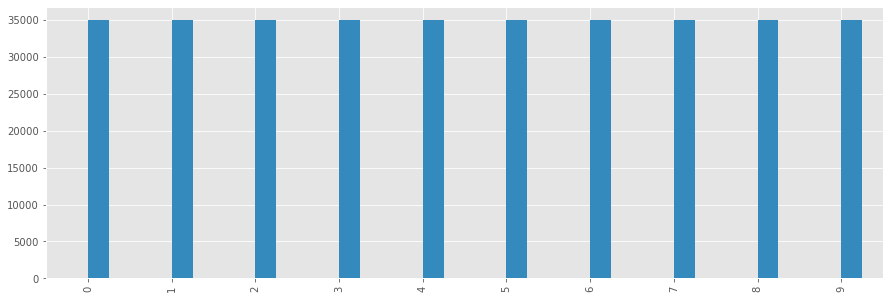

In [127]:
CA = state_df.loc[(state_df['geo_id'] == '06'), ]
CA_quantiles = CA['income_per_capita'].quantile(
    [.1, .2,.3,.4, .5,.6,.7,.8,.9,1]).reset_index().rename(columns = {'index': 'percentile'})
CA_quantiles.plot.bar(figsize=(15, 5), legend= None);                                                                                 #'mean'))

#CA_by_bin = by_bin.quantile([.1, .2,.3,.4, .5,.6,.7,.8,.9,1]).reset_index().rename(columns = {'index': 'percentile'})
#CA_by_bin.plot.bar(figsize=(15, 5), legend=None)